# Prediction of insurance expenses

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
# import time, import datetime

import statsmodels
import os

# Data transformation modules
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Machine Learning modules
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

# Neural Networks modules
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasRegressor

plt.rcParams['figure.figsize'] = [10, 5] #set figure size bigger



## Exploratory analysis

We have the following features to predict the charges of a policyholder in an insurance company:
<ul>
    <li> age: Age of the beneficiary.
    <li> sex: Beneficiary's sex (female/male).
    <li> bmi: Body mass index.
    <li> children: Number of children covered by the insurance.
 <li> smoker: Smoking (yes/no).
<li> region: The beneficiary's residential area in the US (northwest/northeast/southwest/southeast).
<li>charges: Individual medical costs billed by the insurance.
    </ul>

First we will look at the data types of each column and look for missing data in each column. 

In [2]:
df = pd.read_csv("insurance.csv")
df.head()

pd.options.display.float_format = '{:0.4f}'.format #only use 4 floats

In [6]:
df.info() # df.isnull().sum() to see how many missing records in each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [8]:
df.describe().applymap(lambda x: f"{x:0.3f}")

,age,bmi,children,charges
count,1338.000,1338.000,1338.000,1338.000
mean,39.207,30.663,1.095,13270.422
std,14.050,6.098,1.205,12110.011
min,18.000,15.960,0.000,1121.874
25%,27.000,26.296,0.000,4740.287
50%,39.000,30.400,1.000,9382.033
75%,51.000,34.694,2.000,16639.913
max,64.000,53.130,5.000,63770.428


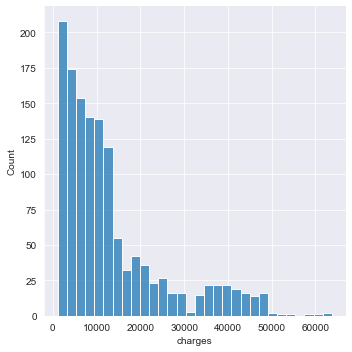

In [7]:
#lets analyze the distribution of the target variable
sns.set_style("darkgrid")
sns.displot(df['charges'])

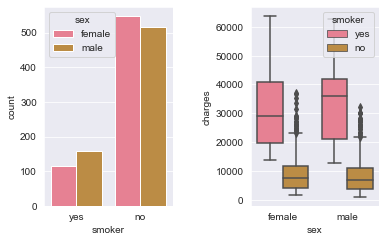

In [8]:
my_palette = sns.color_palette("husl", 8)

fig, ax=plt.subplots(1,2)
sns.countplot(x="smoker", hue = 'sex', palette=my_palette, data=df, ax=ax[0])
sns.boxplot(x="sex", y="charges", hue="smoker", data=df, palette = my_palette, ax=ax[1])
fig.tight_layout(pad=3.0)
plt.show()


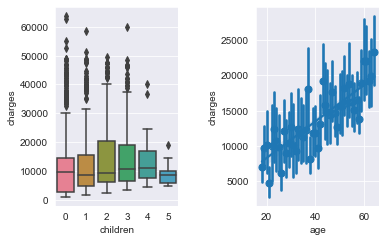

In [9]:
#sns.boxplot(x="sex", y="charges", hue="children", data=df, palette = my_palette)

fig, ax=plt.subplots(1,2)
sns.boxplot(x="children", y="charges", data=df, palette = my_palette, ax = ax[0])
sns.regplot(x="age", y="charges", data=df, x_estimator=np.mean, ax=ax[1])
fig.tight_layout(pad=3.0)
plt.show()

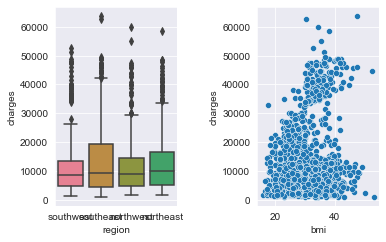

In [11]:
#regions
fig, ax=plt.subplots(1,2)
sns.boxplot(x="region", y="charges", data=df, palette = my_palette, ax = ax[0])
sns.scatterplot(x="bmi", y="charges", data=df, ax=ax[1])
fig.tight_layout(pad=3.0)
plt.show()




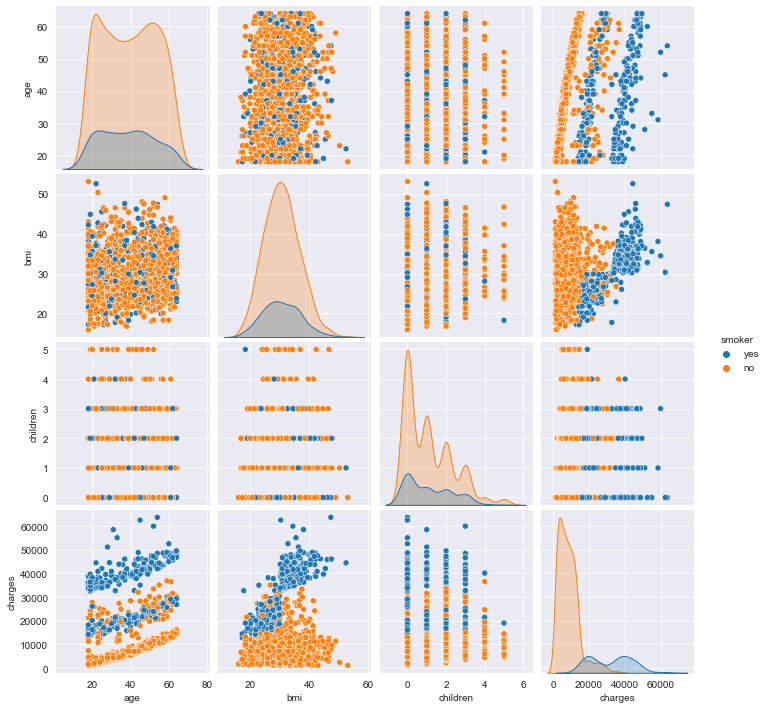

In [13]:
# the effect of smoker on other variables
sns.pairplot(hue="smoker",data=df)


<ul>
    <li> Smokers have higher charges that non-smokers, independently of the sex, and smoking habits are more prevalent among males. 
    <li> Women present more variation in their charges: there is a noticeable difference between the charges of males and females in terms of their variance.
    <li> Males tend to spend more than women.
    <li> Charges increase as the population gets older.
<li> There is no apparent difference in charges between regions and number of children.
    <li> There is a small indication that individuals with higher BMI spend more. 
        <li> There are no remarkable outliers.
</ul>



## Fit of different ML Models

We will first fit some out-of-the-box models and then fine-tune the best ones. We will use LinearRegression, Lasso , Ridge, ElasticNet, RandomForestRegressor, and XGBRegressor. We will use 1/3 of the observations as a test set and the rest to train the models.

In [6]:
X = df.drop('charges', axis=1)
y = df.charges
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 6)

Since we have no missing values, no imputation is needed. We will transform cathegorical variables into one-hot encoding system and normalize the remaining numerical ones.

In [6]:
column_trans = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (StandardScaler(), ['age', 'bmi', 'children']),
    remainder='passthrough')

In [9]:
# functions to evaluate predictions
def model_performance(model, results_df, model_name=None, verbose=0):
    """
    Given a model, this function updates the dataframe results_df with the current model's cross-validation results.
    It also plots the errors with respect to the X_test and y_test sets.
    Parameters are:
    - model: a machine learning model
    - results_df: dataFrame that stores the CV information of the models
    - model_name: a string with the name of the model that is useful in the case of having different instances of the
    same model with different parameters. If set as None, it uses type(model).__name__
    Returns: an updated version of results_df.
    """
    if model_name is None:
        model_name = type(model).__name__
    
    print(model_name)
    
    pipe = make_pipeline(column_trans, model) # cross validation pipeline
    # Results of the CV
    cv_scores = cross_validate(pipe, X_train, y_train, cv=5,
                              scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
                              verbose=verbose, n_jobs=-1) #-1 uses all processors
    # Extracting CV results
    mse_mean = np.sqrt(np.array(-cv_scores['test_neg_mean_squared_error'])).mean()
    mse_std = cv_scores['test_neg_mean_squared_error'].std()
    mae_mean =  np.sqrt(np.array(-cv_scores['test_neg_mean_absolute_error'])).mean()
    mae_std = cv_scores['test_neg_mean_absolute_error'].std()    
    fit_time_mean = cv_scores['fit_time'].mean() 
    
    print(fit_time_mean)
    
    # New row of the results_df dataframe
    new_row = [model_name, mse_mean, mse_std, mae_mean, mae_std]
    
    # Plot of the MSE
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    plt.plot(np.array(y_test)-y_pred)
    plt.title("MSE of "+model_name)
    plt.show()
    
    if results_df.iloc[0,0]== 0: # if results_df is empty
        results_df.loc[0] = new_row
    else:
        results_df.loc[len(results_df.index)] = new_row
    return results_df

def normalized_bar_plot(results_df):
    """
    Bar plot of the normalized errors.
    Parameters:
    -results_df: dataframe with the model's CV errors
    """
    normalized_df = results_df.copy()
    normalized_df.iloc[:,1:]=(results_df.iloc[:,1:].copy())/results_df.iloc[:,1:].max()
    normalized_df.plot(x="model", y=['RMSE mean', 'RMSE std', 'MAE mean', 'MAE std'], kind="bar")
    # plt.ylim([0,2])
    plt.title("Equivalent magnitudes of the CV results")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


LinearRegression
0.01675586700439453


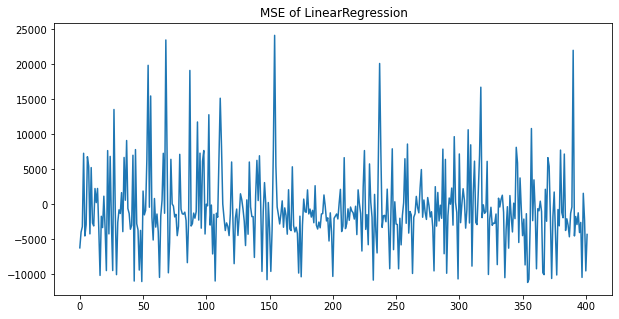

Lasso
0.01615743637084961


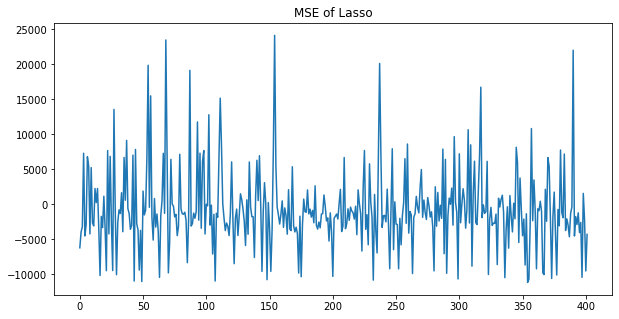

Ridge
0.016557693481445312


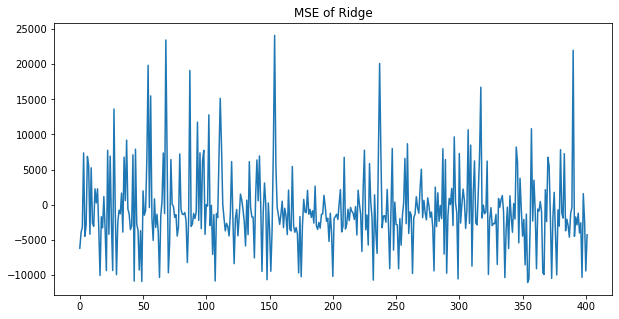

ElasticNet
0.016645193099975586


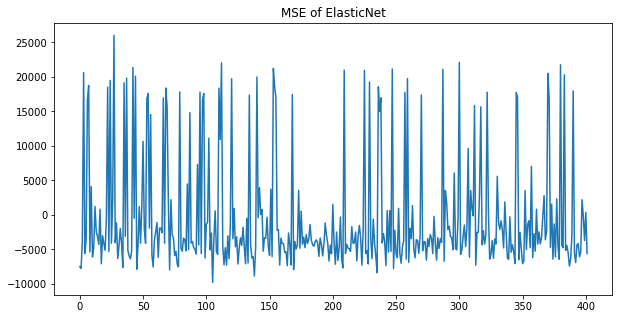

RandomForestRegressor
0.5502287864685058


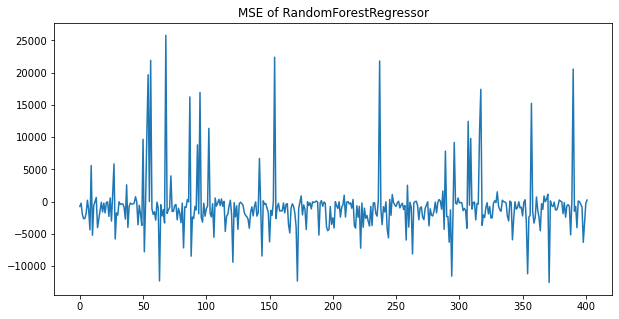

XGBRegressor
0.5405900955200196


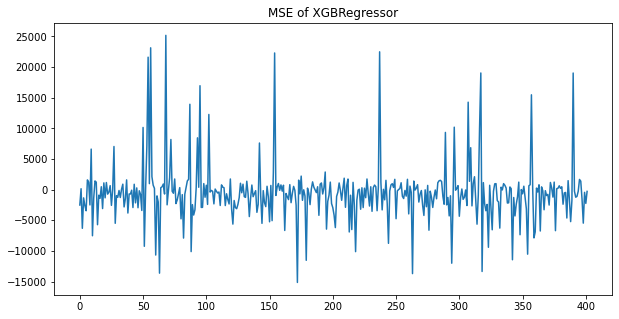

In [18]:
col_results = ['Model', 'RMSE mean', 'RMSE std', 'MAE mean', 'MAE std']
models = [LinearRegression(), Lasso(), Ridge(), ElasticNet(), RandomForestRegressor(), XGBRegressor()]
results_df = pd.DataFrame(np.zeros([1,len(col_results)]), columns=col_results)

for i, model in enumerate(models):
    results_df = model_performance(model, results_df)


In [11]:
results_df

,Model,RMSE mean,RMSE std,MAE mean,MAE std
0,LinearRegression,6338.6541,3554123.3163,66.3015,233.3087
1,Lasso,6338.4686,3562132.8775,66.3001,233.5038
2,Ridge,6338.0526,3635419.2529,66.3493,236.1378
3,ElasticNet,8681.9929,16007589.5480,80.4275,655.5368
4,RandomForestRegressor,5092.4269,3952017.7825,54.5697,288.7697
5,XGBRegressor,5634.6521,5442027.3346,58.4301,404.5645


## Fine tuning 

As we can see from the table above, the best out-of-the-box models are the random forest and the XGBoost regressor. In this section we will fine-tune these two models using a random GridSearchCV to find their optimal parameters, and a Pipeline to control the workflow.

In [16]:
# Fine tune both models in the same search grid
model_1 = RandomForestRegressor()
model_2 = XGBRegressor()


ct = make_pipeline(column_trans, StandardScaler())


# create the Pipeline
pipe = Pipeline([('preprocessor', ct), ('model', model_1)])

# create the parameter dictionary for random forest model
params1 = {}
params1['model__bootstrap'] = [True, False]
params1['model__max_depth'] = [70, 80, 90, 100, 110]
params1['model__max_features'] = [2, 3, 4, 6, 10]
params1['model__min_samples_leaf'] = [2, 3, 4, 5, 6]
params1['model__min_samples_split'] = [5, 8, 10, 12]
params1['model__n_estimators'] = [200, 300, 500, 1000]
params1['model'] = [model_1]

# create the parameter dictionry for XGBoost

my_n_estimators = 1000
params2 = {}
# params1['model__gamma'] = [0]
params2['model__eta'] = [0.4, 0.3, 0.1, 0.01]
params2['model__max_depth'] = [1, 2, 3, 4]
params2['model__n_estimators'] = [my_n_estimators]
params2['model__subsample'] = sp.stats.uniform(scale=1)
params2['model__colsample_bytree'] = sp.stats.uniform(scale=1)
params2['model'] = [model_2]

# create a list of parameter dictionaries
params = [params1, params2]


In [17]:
# Random forest search
grid_RF = RandomizedSearchCV(pipe, params[0], n_jobs=-1, n_iter=20, verbose=1, cv=3, scoring='neg_mean_squared_error',
                             random_state = 6)
grid_RF.fit(X_train, y_train)
grid_RF.best_params_


Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'model__n_estimators': 1000,
 'model__min_samples_split': 12,
 'model__min_samples_leaf': 2,
 'model__max_features': 10,
 'model__max_depth': 70,
 'model__bootstrap': True,
 'model': RandomForestRegressor(max_depth=70, max_features=10, min_samples_leaf=2,
                       min_samples_split=12, n_estimators=1000)}

Tuned Random Forest
3.5546802997589113


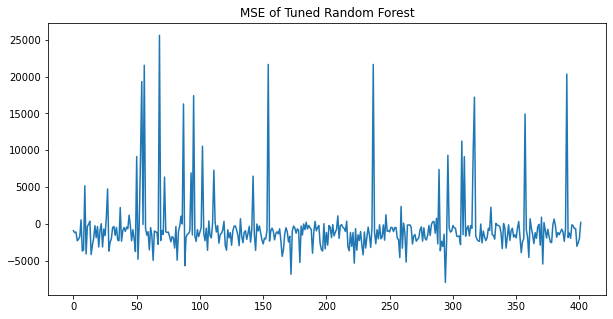

,Model,RMSE mean,RMSE std,MAE mean,MAE std
0,LinearRegression,6338.6541,3554123.3163,66.3015,233.3087
1,Lasso,6338.4686,3562132.8775,66.3001,233.5038
2,Ridge,6338.0526,3635419.2529,66.3493,236.1378
3,ElasticNet,8681.9929,16007589.5480,80.4275,655.5368
4,RandomForestRegressor,5100.8444,3787832.8731,54.7315,247.0130
5,XGBRegressor,5634.6521,5442027.3346,58.4301,404.5645
6,Tuned Random Forest,4868.8623,3873536.7391,53.6730,193.6987


In [19]:
tunedRandomForest = grid_RF.best_params_['model']
results_df = model_performance(tunedRandomForest, results_df, model_name = 'Tuned Random Forest')
results_df

In [20]:
#XGBoost search
grid_XGB = RandomizedSearchCV(pipe, params[1], n_jobs=-1, n_iter=20, verbose=1, cv=3, 
                              random_state = 6)
grid_XGB.fit(X_train, y_train)
grid_XGB.best_params_



Fitting 3 folds for each of 20 candidates, totalling 60 fits


{'model': XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.6713094319392804,
              enable_categorical=False, eta=0.01, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=2,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=0.7173321455555131,
              tree_method=None, validate_parameters=None, verbosity=None),
 'model__colsample_bytree': 0.6713094319392804,
 'model__eta': 0.01,
 'model__max_depth': 2,
 'model__n_estimators': 1000,
 'model__subsample': 0.7173321455555131}

Tuned XGB
1.1959546089172364


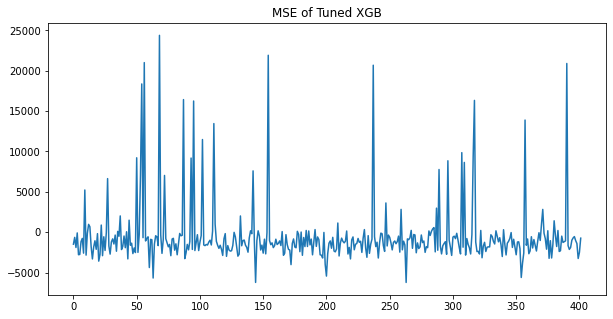

,Model,RMSE mean,RMSE std,MAE mean,MAE std
0,LinearRegression,6338.6541,3554123.3163,66.3015,233.3087
1,Lasso,6338.4686,3562132.8775,66.3001,233.5038
2,Ridge,6338.0526,3635419.2529,66.3493,236.1378
3,ElasticNet,8681.9929,16007589.5480,80.4275,655.5368
4,RandomForestRegressor,5100.8444,3787832.8731,54.7315,247.0130
5,XGBRegressor,5634.6521,5442027.3346,58.4301,404.5645
6,Tuned Random Forest,4868.8623,3873536.7391,53.6730,193.6987
7,Tuned XGB,4801.5242,4447401.4725,53.2035,186.7091


In [21]:
tunedXGB = grid_XGB.best_params_['model']

results_df = model_performance(tunedXGB, results_df, model_name = 'Tuned XGB')
results_df


As seen by the above table, our current best model is the tuned XGB regressor with respect to both the RMSE and MAE means.

## Comparison to neural networks

As a final step, we will compare the performance of all of the above models with a neural network. After doing some testing, we concluded that we don't need a very deep network neither its layers need to have many neurons. We will use a five layer neural network with 128 neurons on the first layer and 64 neurons on the other ones. Since we have a regression problem, the final layer will have one neuron. We incorporated a dropout layer to prevent overfitting, as in CITA. We performed a test without this layer and the network memorizes the data. This is something that we could expect since we have a small dataset. 

As a loss function we choose the MSE, and by testing we found that the activation relu was good enough. 100 epochs were enough to not overfit.

In [23]:
column_trans_NN = make_column_transformer(
    (OneHotEncoder(), ['sex', 'smoker', 'region']),
    (StandardScaler(), ['age', 'bmi', 'children']),
    remainder='passthrough')

X_train_ct = column_trans_NN.fit_transform(X_train)
X_test_ct = column_trans_NN.transform(X_test)

In [24]:
model = Sequential()
model.add(Dense(128, input_dim=len(column_trans_NN.fit_transform(X_train)[0]),  activation='relu'))
model.add(Dropout(0.10))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='relu'))
# Compile model
model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

history = model.fit(X_train_ct, y_train, epochs = 100, validation_split = 0.1, batch_size=1, verbose = 1)
y_pred = model.predict(X_test_ct)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1536      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 14,017
Trainable params: 14,017
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
842/842 [==============================]

In [25]:
history 

In [28]:
# plot the results
mse_test_pred = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test_pred = mean_absolute_error(y_test, y_pred)
print("RMSE test = ", mse_test_pred)
print("MAE test = ", mae_test_pred)
#plt.plot(np.array(y_test)-[i[0] for i in y_pred])
#plt.show()



RMSE test =  4080.7716316925357
MAE test =  2325.996645082109


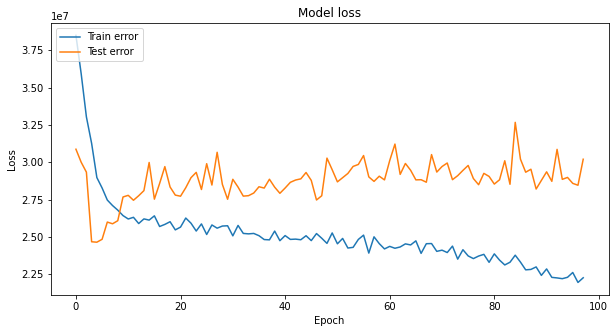

In [27]:
skip_to_plot = 2
plt.plot(history.history['loss'][skip_to_plot:])
plt.plot(history.history['val_loss'][skip_to_plot:])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Validation error', 'Test error'], loc='upper left')
plt.show()

The function create_network wraps the neural network model into a proper form so that it can be used as input for the model_performance function.

In [ ]:
# Create function returning a compiled network
def create_network():
    model = Sequential()
    model.add(Dense(128, input_dim=len(column_trans_NN.fit_transform(X_train)[0]), activation = 'relu'))
    model.add(Dropout(0.10))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(64, activation = 'relu'))
    model.add(Dense(1, activation = 'relu'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer = 'adam')

    return model
# evaluate model
NNmodel = KerasRegressor(build_fn=create_network, epochs = 80, batch_size = 1, verbose = 0)
results_df = model_performance(NNmodel, results_df, model_name = 'Sequential', verbose = 3)
results_df

# keras

The last plot shows that we almost get as small errors with the neural network as the ones with the other models. Nevertheless, we have a remarkably bigger variance in the MAE CV errors and also the computational time was much bigger that the ones of the other models. 

## Conclusions

As a summary of the analysis we could conclude:

<ul>
    <li> An important factor is the smoking feature: the charges are much bigger on people that smokes that on people that don't. The coefficients found on lineal regression and Random Forest algorithms tell us that these two features are very important.
        <li>Random Forest gives a good and fast fit: the Random Forest algorithm give us the smallest errors in comparison to other models. Moreover, the time to train this model was also small. This model has a good equilibrium between accuracy and computational time for the data that we are analyzing.
    <\ul>

        
A bigger data set could be useful to improve the analysis as in this notebook we studied a relatively small dataset. More features or more examples could be useful to discover more particularities of the population. With a bigger dataset we could have an improvement on the company savings, since a more accurate prediction of the costs could lead to the company to offer more competitive prices.